<a href="https://colab.research.google.com/github/nrjcs/iitpbse/blob/master/dl/day5/transer_learning_cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Example

## Transfer learning is a basic appoach of model reuse and retraining
### A model trained on one dataset for a different domain is refined by modifying some of the last layers and trained with new dataset
    * This saves a lot of training time as we only need to modify some of the layers and retrain only those layers
    * Also sometimes we don't have a very big dataset which we can use for training a model so we take pretrained model and retrain it by making only some of the layers trainable
    * This is one of the basic techniques for domain adaptation

### This is a basic example from keras examples directory
(Available @ https://github.com/keras-team/keras/blob/master/examples/mnist_transfer_cnn.py) 

    * - Train a simple convnet on the MNIST dataset the first 5 digits [0..4].
    * - Freeze convolutional layers and fine-tune dense layers for the classification of digits [5..9].
   

Get to 99.8% test accuracy after 5 epochs
for the first five digits classifier
and 99.2% for the last five digits after transfer + fine-tuning.
### Refer to this link for more on sequential models https://keras.io/getting-started/sequential-model-guide/

In [56]:
from __future__ import print_function

import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

now = datetime.datetime.now


In [57]:
batch_size = 128  # no.of elements to be used for one iteration
num_classes = 5   # no. of classes for training
epochs = 5        # how many times the whole dataset should be iterated

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size 
kernel_size = 3  # here kernel_size means a 3x3 filter

if K.image_data_format() == 'channels_first':  # channels mean no. of color channels of the image
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)    # tensorflow uses channels_last config by default

### Define the funtion which will run the training with input model and training data 
    This function basically does some preprocessing on training data and then runs compile and fit functions of keras.models.Sequential 

In [58]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    # compile the model
    # you can chnage the parameters in this compile function
    # custom funtions for loss and opitizer can be used: ref to keras documentation for more
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    # Train the model
    t = now()
    hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Training time: %s' % (now() - t))
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    return hist

In [59]:
# Get the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [60]:

# create two datasets
# one with digits below 5 
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]
print(x_train.shape)
print(x_train[y_train<5].shape)


(60000, 28, 28)
(30596, 28, 28)


In [61]:
print(y_train_lt5.shape)
print(y_train_lt5[1:15])

(30596,)
[4 1 2 1 3 1 4 3 3 1 2 4 0 1]


In [62]:
# digits 5 and above

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5 


In [63]:
print(y_train_gte5[1:15])


[4 0 1 2 3 1 4 4 2 3 1 4 0 1]


In [64]:
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]

In [65]:
# create complete model
model = Sequential(feature_layers + classification_layers)


In [66]:

# train model for 5-digit classification [0..4]
h_org = train_model(model,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Train on 30596 samples, validate on 5139 samples
Epoch 1/1
30596/30596 [==============================] - 49s 2ms/step - loss: 0.1644 - accuracy: 0.9493 - val_loss: 0.0268 - val_accuracy: 0.9909
Training time: 0:00:52.523698
Test score: 0.0267649565969
Test accuracy: 0.990854263306


In [67]:
print(type(h_org))
print(h_org.history.keys())
print(model.metrics_names)

<class 'keras.callbacks.callbacks.History'>
['loss', 'val_accuracy', 'val_loss', 'accuracy']
['loss', 'accuracy']


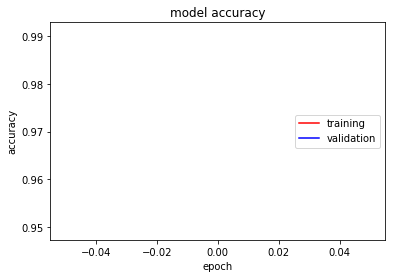

In [68]:
# plot accuracy over the epochs
from matplotlib import pyplot as plt
plt.plot(h_org.history['accuracy'],'r')
plt.plot(h_org.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='center right')
plt.show()

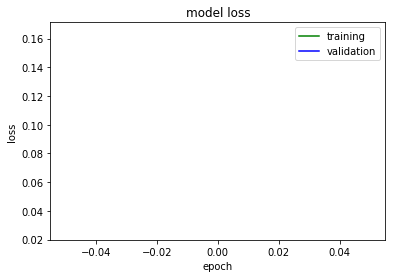

In [69]:
# Behviour of loss over the epochs

plt.plot(h_org.history['loss'],'g')
plt.plot(h_org.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Model trained in the above block can be used for classifying digits 5 to 9 by fine tuning it
    For fine tuning we will freeze all the convolutional and maxpooling layers (feature layers)
    This can be done by making those layers non-trainable
    only the top(last) two layers (dense layers) are left trainable

In [70]:
# freeze feature layers and rebuild model
for l in feature_layers:
    l.trainable = False


In [71]:

# transfer: train dense layers for new classification task [5..9]
h_retr = train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Train on 29404 samples, validate on 4861 samples
Epoch 1/1
29404/29404 [==============================] - 17s 576us/step - loss: 0.2166 - accuracy: 0.9336 - val_loss: 0.0659 - val_accuracy: 0.9788
Training time: 0:00:19.347691
Test score: 0.0659246324218
Test accuracy: 0.978810966015


In [72]:
print(h_retr.history.keys())

['loss', 'val_accuracy', 'val_loss', 'accuracy']


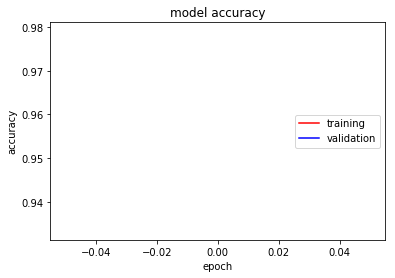

In [73]:
# plot accuracy over the epochs
from matplotlib import pyplot as plt
plt.plot(h_retr.history['accuracy'],'r')
plt.plot(h_retr.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='center right')
plt.show()

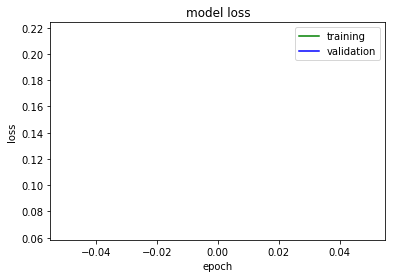

In [74]:
# Behviour of loss over the epochs
plt.plot(h_retr.history['loss'],'g')
plt.plot(h_retr.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

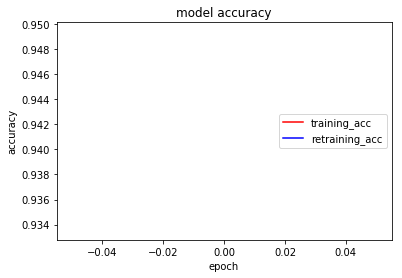

In [75]:
# Let's plot the accuracy of training and retrain over the epochs

# plot accuracy over the epochs
from matplotlib import pyplot as plt
plt.plot(h_org.history['accuracy'],'r')
plt.plot(h_retr.history['accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training_acc', 'retraining_acc'], loc='center right')
plt.show()